## RFM segmentation

Using Python, build an RFM-based user segmentation to assess your audience qualitatively.

The following metrics can be used in segmentation: 
- R - the time from the user's last purchase to the current date, 
- F - total number of user's purchases over the entire time, 
- M - revenue per user: the sum of purchases for the entire time. 

Describe in detail how you created the clusters. 

For each RFM segment, construct the boundaries of the recency, frequency, and monetary metrics to interpret these clusters. 

_Description example:_
- RFM-segment 132 (recency=1, frequency=3, monetary=2) has the boundaries of metrics recency from 130 to 500 days, frequency from 2 to 5 orders per week, and monetary from 1780 to 3560 USD per week.*

In [29]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

Let's recreate the `purchases_users` table, which contains only records that we consider a purchase, as well as the user's unique ID.

In [30]:
orders = pd.read_csv('olist_orders_dataset.csv', 
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                  'order_delivered_carrier_date', 'order_delivered_customer_date',
                                 'order_estimated_delivery_date'])
items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
customers = pd.read_csv('olist_customers_dataset.csv')

In [31]:
purchases = orders.loc[orders.order_status.isin(['delivered', 'shipped'])]
purchases_users = customers[['customer_id', 'customer_unique_id']].merge(purchases, on='customer_id', how='left')

In [32]:
purchases_users.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


Calculating each order's total price

In [33]:
orders_price = items.groupby('order_id', as_index=False).agg({'price': 'sum'})

Adding the order's total price to purchases and selecting only records from the last year of observations

In [34]:
start_date = purchases_users.order_purchase_timestamp.max() - timedelta(days=365)
purchases_price = purchases_users.merge(orders_price, on='order_id')
purchases_price = purchases_price.loc[purchases_price['order_purchase_timestamp'] >= start_date]
purchases_price.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,230.00
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,259.90


Let the current date be the day following the last observations

In [35]:
today = purchases_price['order_purchase_timestamp'].max() + timedelta(days=1)
today

Timestamp('2018-09-04 09:06:57')

Adding column `R` - the time from the user's purchase to the current date, rounded to days.

In [36]:
purchases_price['R'] = (today - purchases_price.order_purchase_timestamp).dt.days
purchases_price.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price,R
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,289.00,234
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,139.94,107
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,149.94,174
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,230.00,36
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,259.90,354


Let's group by unique user ID and calculate the total number of:
- the time from the last purchase to the current date: `R`,
- user purchases for the period of interest: `F`, 
- the amount of money spent during the period of interest: `M`

In [37]:
rfm = purchases_price.groupby('customer_unique_id', as_index=False) \
                    .agg({'R': 'min', 'order_id': 'count', 'price': 'sum'}) \
                    .rename(columns={'order_id': 'F', 'price': 'M'})
rfm.head()

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00


R values exploration

In [38]:
rfm.R.describe()

count    72722.000000
mean       176.570515
std         98.836206
min          1.000000
25%         92.000000
50%        176.000000
75%        264.000000
max        365.000000
Name: R, dtype: float64

We can see that purchases are evenly distributed across the year of observation.

Let's check the top days by purchase.

In [39]:
rfm.R.value_counts().head()

R
283    1037
284     427
282     411
281     388
280     372
Name: count, dtype: int64

The highest number of purchases is observed on the 283rd day from the current date, let's see what the date was:

In [40]:
today - timedelta(days=283)

Timestamp('2017-11-25 09:06:57')

The highest number of purchases occurred on Black Friday.

Let's explore the distribution of the number of purchases per year.

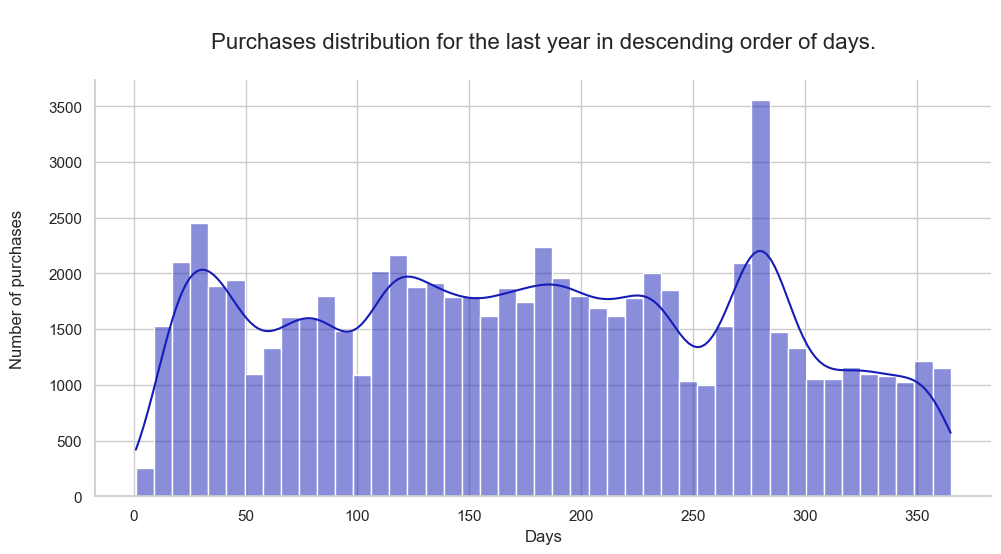

In [41]:
sns.set(style="whitegrid")

g = sns.displot(rfm['R'], kde=True, height=5, aspect=2, color='#161CB6')

plt.xlabel('Days')
plt.ylabel('Number of purchases\n')
plt.title('\nPurchases distribution for the last year in descending order of days.\n', fontsize=16)

plt.show()


The 283rd day marks the highest point, with minor ups and downs throughout the rest of the period.

Let's explore the loyalty parameter.

In [42]:
rfm.F.describe()

count    72722.000000
mean         1.027419
std          0.186128
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: F, dtype: float64

Most users have one purchase

Let's take a look at the top purchases

In [43]:
rfm.F.value_counts()

F
1     70900
2      1702
3        94
4        16
5         5
7         3
9         1
11        1
Name: count, dtype: int64

Let's check how many users made multiple purchases.

In [44]:
all_users = rfm.customer_unique_id.nunique()
users_over1 = rfm.loc[rfm.F > 1].customer_unique_id.nunique()
users_over2 = rfm.loc[rfm.F > 2].customer_unique_id.nunique()
print(f'{round(users_over1 * 100 / all_users, 2)}% of users ({users_over1}) made more than one purchase')
print(f'{round(users_over2 * 100 / all_users, 2)}% of users ({users_over2}) made more than two purchases')

2.51% of users (1822) made more than one purchase
0.17% of users (120) made more than two purchases


Let's explore the profitability metrics

In [45]:
rfm.M.describe()

count    72722.000000
mean       140.908235
std        211.365398
min          0.850000
25%         47.900000
50%         89.800000
75%        152.000000
max      13440.000000
Name: M, dtype: float64

Purchases vary from  0.85 to 13440 USD per purchase, with a median of 89 and an average check of 141 USD. More significant purchases are rare on our platform.

Let's look at users with the maximum amount of purchases.

In [46]:
rfm.loc[rfm.M >= rfm.M.mean() * 10]

,customer_unique_id,R,F,M
96,005226be8d5b972d0f72b4e8a79f322b,155,1,1561.0
195,00adeda9b742746c0c66e10d00ea1b74,300,1,2078.5
224,00c07da5ba0e07b4f248a3a373b07476,38,1,2258.0
345,012a218df8995d3ec3bb221828360c86,77,2,1429.8
451,01858f2fad256b1689f5bdafc059f745,34,1,1799.0
...,...,...,...,...
71678,fc54c2c09aee36da48881e5bf37ef795,262,1,2680.0
72188,fe203d7588a60b447f5c5f089b967097,108,1,1599.0
72309,fe81bb32c243a86b2f86fbf053fe6140,74,5,1535.4
72368,fec38f6590f4d8e78563eacd15f0413c,149,1,1880.0


Users who make the most significant purchases tend to do so only once, at various times throughout the year.

We can see a significant difference between the maximum and average check, with the former being almost a hundred times higher.

Let's examine the number of users who purchase ten times the average since the 75th quartile is close to the average.

In [47]:
rfm.loc[rfm.M >= rfm.M.mean() * 10]

,customer_unique_id,R,F,M
96,005226be8d5b972d0f72b4e8a79f322b,155,1,1561.0
195,00adeda9b742746c0c66e10d00ea1b74,300,1,2078.5
224,00c07da5ba0e07b4f248a3a373b07476,38,1,2258.0
345,012a218df8995d3ec3bb221828360c86,77,2,1429.8
451,01858f2fad256b1689f5bdafc059f745,34,1,1799.0
...,...,...,...,...
71678,fc54c2c09aee36da48881e5bf37ef795,262,1,2680.0
72188,fe203d7588a60b447f5c5f089b967097,108,1,1599.0
72309,fe81bb32c243a86b2f86fbf053fe6140,74,5,1535.4
72368,fec38f6590f4d8e78563eacd15f0413c,149,1,1880.0


In [48]:
f'As a percentage of all users - {round(202 * 100 / all_users, 2)}'

'As a percentage of all users - 0.28'

Out of all users, only 0.25% are part of the group of 202 individuals who spend ten times more than the average amount.

#### Since users are more likely to make a single purchase, we are interested in highlighting users who:

- **New**: made a purchase recently
    - 1 point: 25% of users who have purchased in the past 92 days
    - 0 points: users who have purchased 93+ days ago 
- **Loyal**: have made more than one purchase
    - 1 point: two or more purchases
    - 0 points: one purchase
- **Profitable**: spent more money than average
    - 1 point: 25% of users who made a purchase for an amount greater than the 75th quantile
    - 0 points: users who made a purchase for an amount less than the 75th quantile
    
Let's start with adding R_score

In [49]:
quintiles = rfm['R'].quantile([.25, .5]).to_dict()

def r_score(x):
    if x <= quintiles[0.25]:
        return 1
    else:
        return 0

rfm['R_score'] = rfm.R.apply(r_score)
rfm.head()

,customer_unique_id,R,F,M,R_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0


Let's calculate the loyalty score by adding F_score.

In [50]:
def f_score(x):
    if x > 1:
        return 1
    else:
        return 0


rfm['F_score'] = rfm.F.apply(f_score)
rfm.sort_values('F_score', ascending=False).head()

,customer_unique_id,R,F,M,R_score,F_score
63524,df2a9226267aa1598b499b3ea09fcf60,51,2,200.00,1,1
40959,9099c659f8cd764e87a1482d258fcec9,188,2,311.40,0,1
32712,731ea3afd190908a9cbed04f42aa51e2,280,2,269.70,0,1
32706,731a127666e5bc79810ebdc48eeff385,202,2,177.85,0,1
68492,f0e310a6839dce9de1638e0fe5ab282a,152,4,175.19,0,1


Let's calculate user's profitability by adding M_score

In [51]:
quintiles = rfm['M'].quantile([.75]).to_dict()
def m_score(x):
    if x >= quintiles[0.75]:
        return 1
    else:
        return 0

rfm['M_score'] = rfm.M.apply(m_score)
rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,1
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,1


In [52]:
r_scores = rfm['R_score'].value_counts().to_frame().reset_index()
f_scores = rfm['F_score'].value_counts().to_frame().reset_index()
m_scores = rfm['M_score'].value_counts().to_frame().reset_index()

In [53]:
r_scores

,R_score,count
0,0,54519
1,1,18203


Let's visualize the distribution of our users across R_score, F_score, M_score:

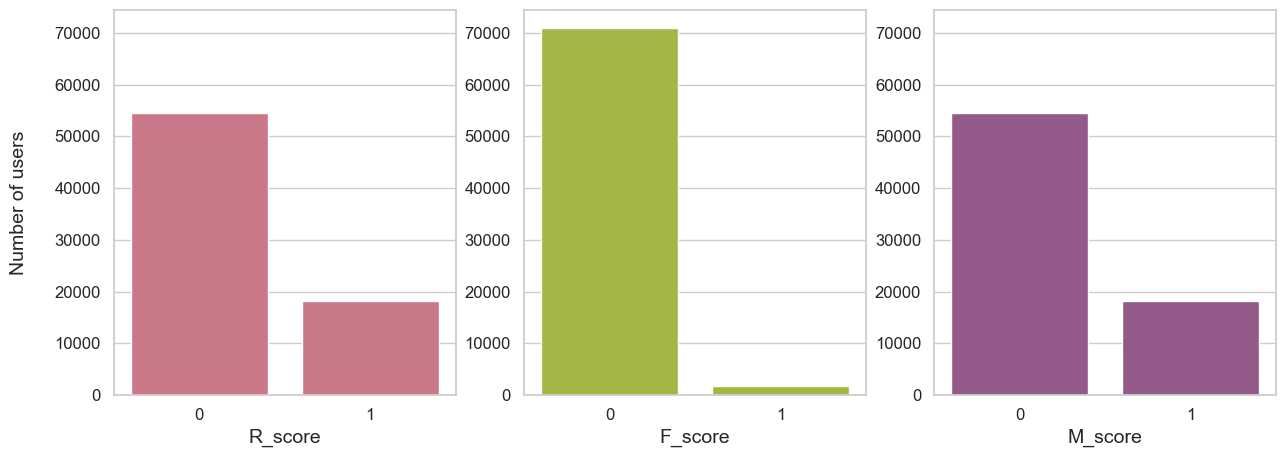

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style("white")

title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12

sns.barplot(data=r_scores, x='R_score', y='count', color='#D66B7F', ax=axes[0])
axes[0].set_ylabel('Number of users\n', fontsize=label_fontsize)
axes[0].set_xlabel('R_score', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

sns.barplot(data=f_scores, x='F_score', y='count', color='#B3C733', ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('F_score', fontsize=label_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

sns.barplot(data=m_scores, x='M_score', y='count', color='#9B5090', ax=axes[2])
axes[2].set_ylabel('')
axes[2].set_xlabel('M_score', fontsize=label_fontsize)
axes[2].tick_params(axis='both', labelsize=tick_fontsize)

y_max = max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(0, y_max)

plt.show()

The scores are distributed differently depending on the metric:
- **R, Recentness**: about a quarter of users have made a purchase recently
- **F, Loyalty**: most users make one purchase. 2 or more purchases are rare
- **M, Profitability**: about 2/3 of users make a purchase for less than the average check.

The majority of our customers make a single purchase for a relatively small sum of money.

##### Let's calculate the full RFM_Score for each user:

In [55]:
rfm['RFM_Score'] = rfm['R_score'].map(str) + rfm['F_score'].map(str) + rfm['M_score'].map(str)
rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,000
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,000
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,000
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,1,001
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,1,001


Let's check the distribution of the groups:

In [57]:
rfm['RFM_Score'].value_counts()

RFM_Score
000    40314
100    13494
001    12913
101     4179
011      777
010      515
111      328
110      202
Name: count, dtype: int64

#### User segmentation:


* 111 - **"Champions "**, the best users, our rockstars
* 101 - **"Valuable "** - made one purchase recently, but for an above-average amount
* 011 - **"Important "** - made several above-average purchases.
* 110 - **"Promising "** - made several recent purchases
* 100 - **"New "** - made a one-time purchase recently
* 001 - **"Profitable "** - made an above-average one-time purchase.
* 010 - **"Loyal "** - made more than one purchase.
* 000 - **"One-time "** - made a one-time purchase a long time ago for a small amount.


In total, we have eight groups.

Let's add segments for each user:

In [58]:
def grouping(x):
    if x == '000':
        return "One-time"
    elif x == '010':
        return "Loyal"
    elif x == '001':
        return "Profitable"
    elif x == '100':
        return "New"
    elif x == '110':
        return "Promising"
    elif x == '011':
        return "Important"
    elif x == '101':
        return "Valuable"
    else:
        return "Champions"


rfm['Group'] = rfm.RFM_Score.apply(grouping)

rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,RFM_Score,Group
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,000,One-time
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,000,One-time
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,000,One-time
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,1,001,Profitable
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,1,001,Profitable


Let's group the segments by counting the number of users in each in absolute values and in percentages

In [59]:
rfm_g = rfm['Group'].value_counts().to_frame().reset_index().rename(columns={'index': 'Group', 'count': 'Users'}) \
                    .sort_values('Users')
rfm_g['Percentage'] = rfm_g['Users']/rfm_g['Users'].sum() * 100
rfm_g

,Group,Users,Percentage
7,Promising,202,0.277770
6,Champions,328,0.451033
5,Loyal,515,0.708176
4,Important,777,1.068452
3,Valuable,4179,5.746542
2,Profitable,12913,17.756662
1,New,13494,18.555595
0,One-time,40314,55.435769


*New* and *Recent* users are the majority of our customers (35% in each group)

Let's display user segmentation

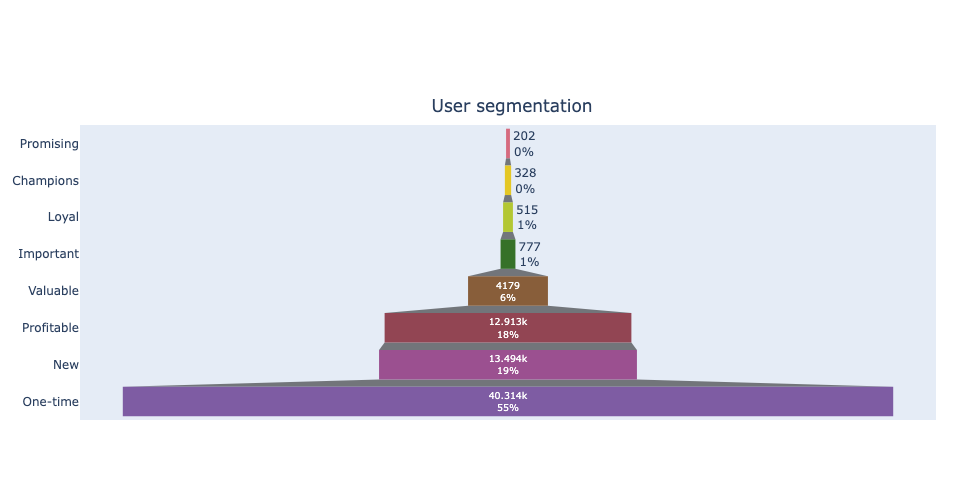

In [89]:
fig = go.Figure()

colors = [ '#D66B7F', '#E4C725','#B3C733', 
                      '#367128', '#885E3A', '#924553', '#9B5090', '#7E5CA3']

fig.add_trace(go.Funnel(
    x=rfm_g['Users'],
    y=rfm_g['Group'],
    orientation='h',
    textinfo='value+percent total',
    marker={'color': colors},
    customdata=rfm_g.apply(lambda row: \
                           f"{row['Group']}:<br>{row['Users']} users,<br>{row['Percentage']:.2f}% \
                           out of all users<extra></extra>", axis=1)
))


fig.update_layout(
    title={
        'text': 'User segmentation',
        'y': 0.8,
        'x': 0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    margin=dict(r=30, t=125),
    height=500
)

#fig.update_yaxes(margin=dict(t=15))

fig.update_traces(hovertemplate='%{customdata}')

fig.show()

About 75% of users fall under the "One-time" and "New" segments. Meanwhile, the remaining 25% have a higher average spend and more frequent purchases than these two groups.

Let's examine the revenue, average purchases, and median number of newcomers for each group within each segment.

To represent our data, we have chosen the following factors:
- **R**, which stands for the last user activity. To compare the average across groups, we are using the median to ensure that outliers do not affect our data.
- **F**, which represents the frequency of purchases. Since the data ranges from 1 to 9 with a maximum of one purchase, we prefer to use the usual average. It gives us a decimal number that is unique to each group.
- **M**, which indicates the profit. We are most interested in the income we receive from the whole group, so we will choose the sum of all purchases.

In [93]:
groups = rfm.groupby('Group', as_index=False).agg({'R': 'median', 'F': 'mean', 'M': 'sum'})
groups['R'] = 365 - groups.R
groups['Color'] = [ '#924553', '#E4C725', '#9B5090', '#B3C733', '#367128',
                   '#7E5CA3', '#D66B7F', '#CB2A3A']

In [94]:
groups

,Group,R,F,M,Color
0,Champions,318.0,2.189024,120227.12,#924553
1,Important,169.0,2.118404,284039.71,#E4C725
2,Loyal,160.0,2.023301,49453.16,#9B5090
3,New,320.0,1.000000,950781.25,#B3C733
4,One-time,149.0,1.000000,2852949.35,#367128
5,Profitable,149.0,1.000000,4490951.40,#7E5CA3
6,Promising,318.0,2.029703,19450.75,#D66B7F
7,Valuable,319.0,1.000000,1479275.95,#CB2A3A


Let's plot the distribution of each metric

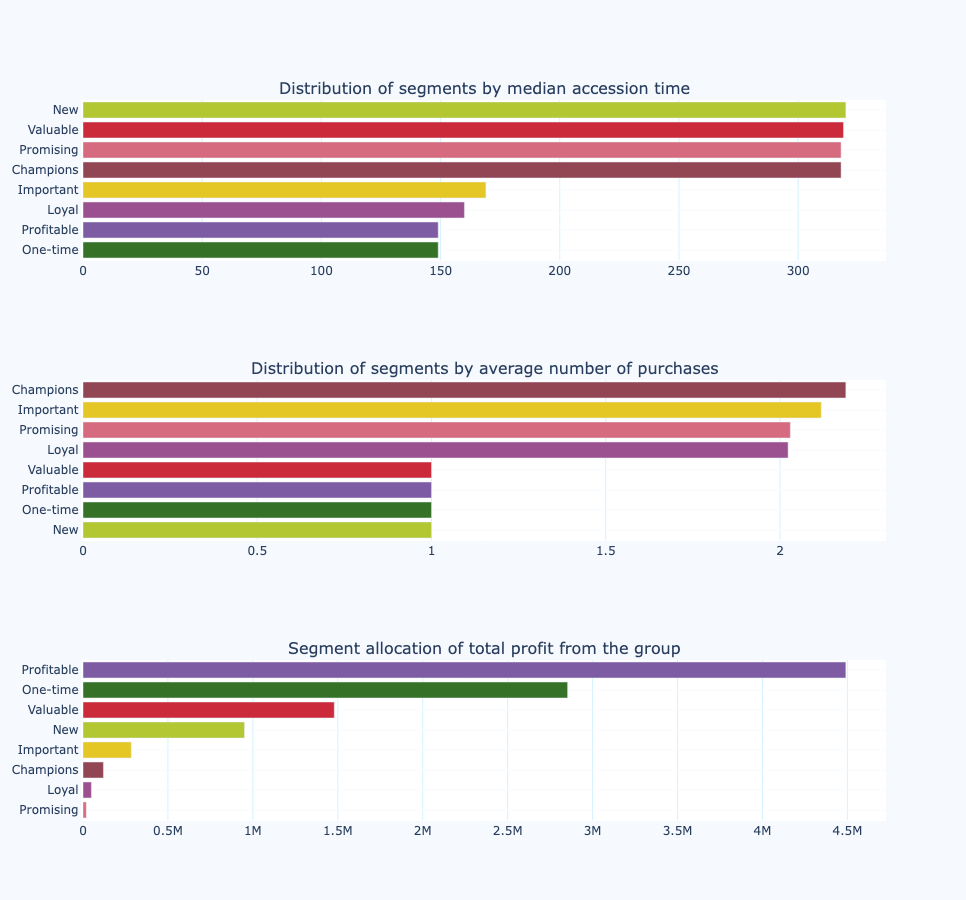

In [95]:
R_sorted = groups.sort_values('R')
F_sorted = groups.sort_values('F')
M_sorted = groups.sort_values('M')

fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, 
        subplot_titles=['Distribution of segments by median accession time', 
                        'Distribution of segments by average number of purchases', 
                        'Segment allocation of total profit from the group'])

fig.add_trace(go.Bar(y=R_sorted['Group'], x=R_sorted['R'], orientation='h', 
                     marker=dict(color=R_sorted['Color']), name='R'), row=1, col=1)
fig.add_trace(go.Bar(y=F_sorted['Group'], x=F_sorted['F'], orientation='h', 
                     marker=dict(color=F_sorted['Color']), name='F'), row=2, col=1)
fig.add_trace(go.Bar(y=M_sorted['Group'], x=M_sorted['M'], orientation='h', 
                     marker=dict(color=M_sorted['Color']), name='M'), row=3, col=1)

fig.update_layout(height=900, showlegend=False, plot_bgcolor="white", paper_bgcolor="#F6FAFF")
fig.update_xaxes(showline=True, linewidth=1, gridcolor='#D4F2FF')
fig.update_yaxes(showline=True, linewidth=2, gridcolor="#F6FAFF")

fig.show()


### Conclusions and observations

**"Champions"** are the top purchasers, but they bring little profit due to few users.

**"Promising", "Loyal"**, and **"Important"** users generate a high average number of purchases but yield a low total profit.

The **"Profitable"** segment generates the highest profit, with a gap of almost one-third from the largest segments - **"Valuable"** and **"One-Time"**. 

In the future, we can conduct a more detailed analysis of each segment to identify behavior patterns and potential influence points on users. Based on this analysis, we can develop and implement marketing campaigns that aim to achieve the following goals:
- Expand our customer base by targeting new customers, as they represent the majority of our audience.
- Encourage customers to make repeat purchases and convert them into loyal customers.
- Retain customers who have shown interest in our products or services and have potential for future sales.
- Increase sales to our largest customers in order to boost our overall revenue.
- Reward our most valuable customers for their loyalty and continued business.
